# BOW and TFIDF

```yaml
course:   DS 5001 
module:   05 5 Lab
topic:    BOW and TFIDF
author:   R.C. Alvarado
date:     13 February 2024
```

# Set Up

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px

In [2]:
sns.set()

## Config

Change this to match the location of your data files.

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [4]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [36]:
bag = 'CHAPS'
# bag = 'BOOKS'

# Prepare the data

## Import tables

In [38]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
TOKEN = pd.read_csv(f'{output_dir}/{data_prefix}-TOKEN.csv').set_index(OHCO).dropna()
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB_RANKED.csv').set_index('term_str').dropna()
# POS_GROUP = pd.read_csv(f'{output_dir}/{data_prefix}-POS_GROUP.csv').set_index('pos_group')

# Create BOW from TOKEN

We can create a BOW with a **split-apply-combine** pattern that counts instances of words for each bag.

We group by `bag + ['term_str']`.


In [39]:
BOW = TOKEN.groupby(bags[bag]+['term_str']).term_str.count().to_frame('n') 

In [40]:
BOW.head()

n
book_id chap_num term_str   
105     1        1         2
                 15        1
                 16        1
                 1760      1
                 1784      1

# Document-Term Count Matrix

We create a document-term count matrix simply bu **unstacking** the BOW, which converts it from a narrow to a wide representation. 

Note, these operations are slower than using `groupby()`.

In [41]:
DTCM = BOW.n.unstack(fill_value=0)

In [42]:
DTCM.head(10)

term_str          0  1  10  100  1000  10000  1000000  10000000  10440  10800  \
book_id chap_num                                                                
105     1         0  2   0    0     0      0        0         0      0      0   
        2         0  0   0    0     0      0        0         0      0      0   
        3         0  0   0    0     0      0        0         0      0      0   
        4         0  0   0    0     0      0        0         0      0      0   
        5         0  0   0    0     0      0        0         0      0      0   
        6         0  0   0    0     0      0        0         0      0      0   
        7         0  0   0    0     0      0        0         0      0      0   
        8         0  0   0    0     0      0        0         0      0      0   
        9         0  0   0    0     0      0        0         0      0      0   
        10        0  0   0    0     0      0        0         0      0      0   

term_str          ...  zoroaster  zozo  zuma  zur  à  æneas  æniad  æson  \
book_id chap_num  ...                                                      
105     1         ...          0     0     0    0  0      0      0     0   
        2         ...          0     0     0    0  0      0      0     0   
        3         ...          0     0     0    0  0      0      0     0   
        4         ...          0     0     0    0  0      0      0     0   
        5         ...          0     0     0    0  0      0      0     0   
        6         ...          0     0     0    0  0      0      0     0   
        7         ...          0     0     0    0  0      0      0     0   
        8         ...          0     0     0    0  0      0      0     0   
        9         ...          0     0     0    0  0      0      0     0   
        10        ...          0     0     0    0  0      0      0     0   

term_str          æsops  ł20000  
book_id chap_num                 
105     1             0       0  
        2             0       0  
        3             0       0  
        4             0       0  
        5             0       0  
        6             0       0  
        7             0       0  
        8             0       0  
        9             0       0  
        10            0       0  

[10 rows x 40478 columns]

In [43]:
DTCM.sum()

term_str
0          2
1         18
10         6
100        2
1000       2
          ..
æneas      1
æniad      1
æson       2
æsops      1
ł20000     1
Length: 40478, dtype: int64

## Interlude: Types and Tokens by DOC

DOC is a table of bags.

We call TYPE/TOKEN ratio PKR.

PKR varies by bag.

In [44]:
DOC = DTCM.sum(1).to_frame('n_tokens')
DOC['n_types'] = DTCM.astype('bool').sum(1)
DOC['pkr'] = DOC.n_types / DOC.n_tokens
DOC = DOC.join(LIB[['author','title']])

In [68]:
DOC.sort_values('pkr').head(20).style.background_gradient(cmap='YlGnBu')

CHAPS


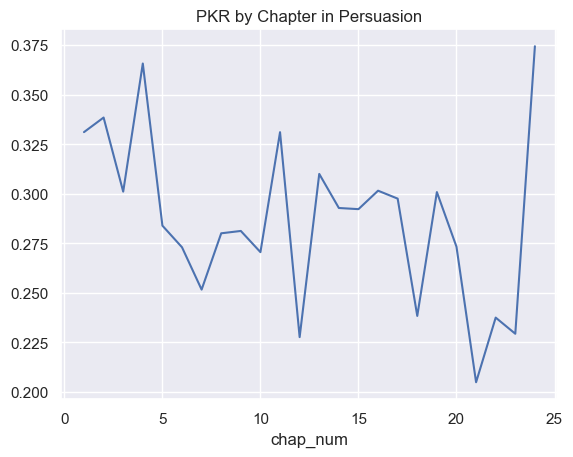

In [46]:
print(bag)
if bag == 'CHAPS':
    DOC.loc[105, 'pkr'].plot(title="PKR by Chapter in Persuasion", label='title');

# Compute TFIDF

In [47]:
tf_method = 'sum'         # sum, max, log, double_norm, raw, binary
tf_norm_k = .5            # only used for double_norm
idf_method = 'standard'   # standard, max, smooth
gradient_cmap = 'YlGnBu'  # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

## Compute TF

In [48]:
# We could do all this directly in the BOW table
# BOW.groupby(['book_id','chap_num']).apply(lambda x: x.n / x.n.sum())

In [49]:
print('TF method:', tf_method)

if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()

elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'log':
    TF = np.log2(1 + DTCM.T)
    
elif tf_method == 'raw':
    TF = DTCM.T
    
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
    
TF = TF.T

TF method: sum


In [50]:
TF.head()

term_str            0         1   10  100  1000  10000  1000000  10000000  \
book_id chap_num                                                            
105     1         0.0  0.000762  0.0  0.0   0.0    0.0      0.0       0.0   
        2         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   
        3         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   
        4         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   
        5         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   

term_str          10440  10800  ...  zoroaster  zozo  zuma  zur    à  æneas  \
book_id chap_num                ...                                           
105     1           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        2           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        3           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        4           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        5           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   

term_str          æniad  æson  æsops  ł20000  
book_id chap_num                              
105     1           0.0   0.0    0.0     0.0  
        2           0.0   0.0    0.0     0.0  
        3           0.0   0.0    0.0     0.0  
        4           0.0   0.0    0.0     0.0  
        5           0.0   0.0    0.0     0.0  

[5 rows x 40478 columns]

## Compute DF

In [51]:
DF = DTCM.astype('bool').sum() 

In [52]:
DF

term_str
0          1
1         11
10         5
100        2
1000       2
          ..
æneas      1
æniad      1
æson       1
æsops      1
ł20000     1
Length: 40478, dtype: int64

## Compute IDF

In [53]:
N = DTCM.shape[0]

In [54]:
print('IDF method:', idf_method)

if idf_method == 'standard':
    IDF = np.log2(N / DF)

elif idf_method == 'max':
    IDF = np.log2(DF.max() / DF) 

elif idf_method == 'smooth':
    IDF = np.log2((1 + N) / (1 + DF)) + 1

IDF method: standard


In [55]:
IDF

term_str
0         10.131857
1          6.672425
10         7.809929
100        9.131857
1000       9.131857
            ...    
æneas     10.131857
æniad     10.131857
æson      10.131857
æsops     10.131857
ł20000    10.131857
Length: 40478, dtype: float64

## Compute TFIDF

In [56]:
TFIDF = TF * IDF

In [57]:
TFIDF.head()

term_str            0         1   10  100  1000  10000  1000000  10000000  \
book_id chap_num                                                            
105     1         0.0  0.005084  0.0  0.0   0.0    0.0      0.0       0.0   
        2         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   
        3         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   
        4         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   
        5         0.0  0.000000  0.0  0.0   0.0    0.0      0.0       0.0   

term_str          10440  10800  ...  zoroaster  zozo  zuma  zur    à  æneas  \
book_id chap_num                ...                                           
105     1           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        2           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        3           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        4           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        5           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   

term_str          æniad  æson  æsops  ł20000  
book_id chap_num                              
105     1           0.0   0.0    0.0     0.0  
        2           0.0   0.0    0.0     0.0  
        3           0.0   0.0    0.0     0.0  
        4           0.0   0.0    0.0     0.0  
        5           0.0   0.0    0.0     0.0  

[5 rows x 40478 columns]

## Move things to their places

In [58]:
VOCAB['df'] = DF
VOCAB['idf'] = IDF

In [59]:
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

# Apply

In [60]:
def top_books_for_term(term_str):
    X = BOW.join(LIB).query(f"term_str == '{term_str}'").groupby(['author','title'])\
        .agg({'tfidf':'mean', 'n':'sum', 'tf':'sum'})
    return px.scatter(X.reset_index(), 'n','tfidf', color='author', size='tf',
                      hover_name='title', 
                      height=500, width=600, title=f"{term_str}")

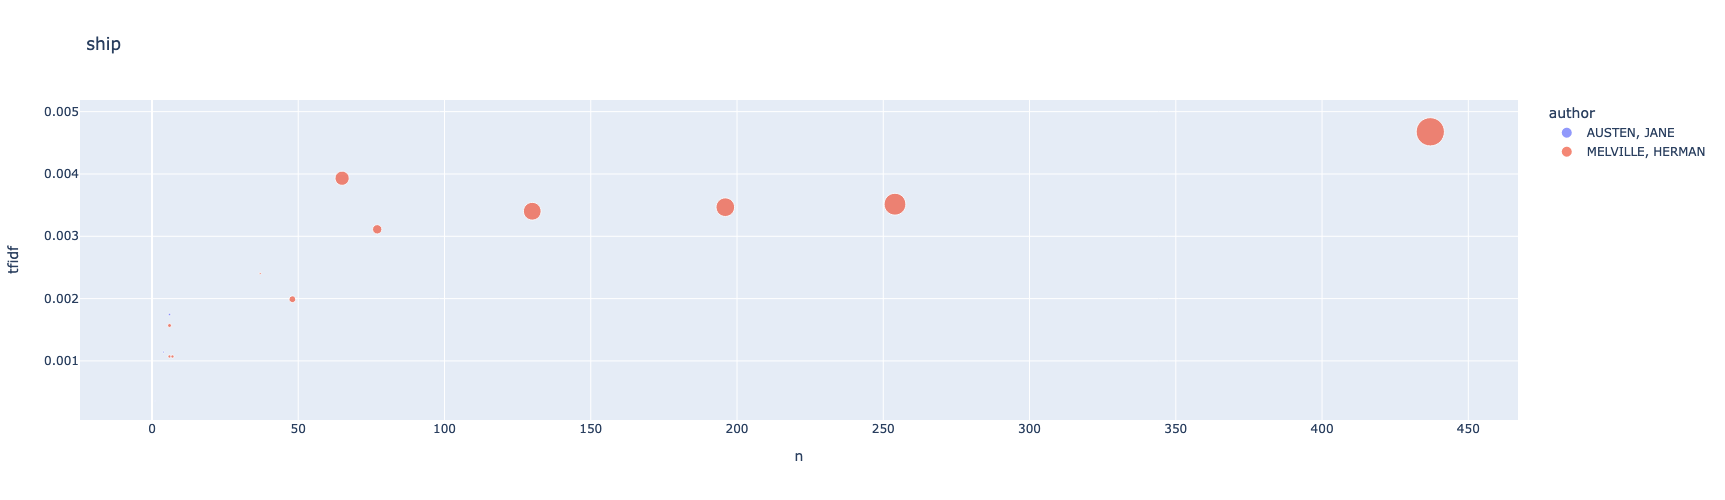

In [61]:
top_books_for_term('ship')

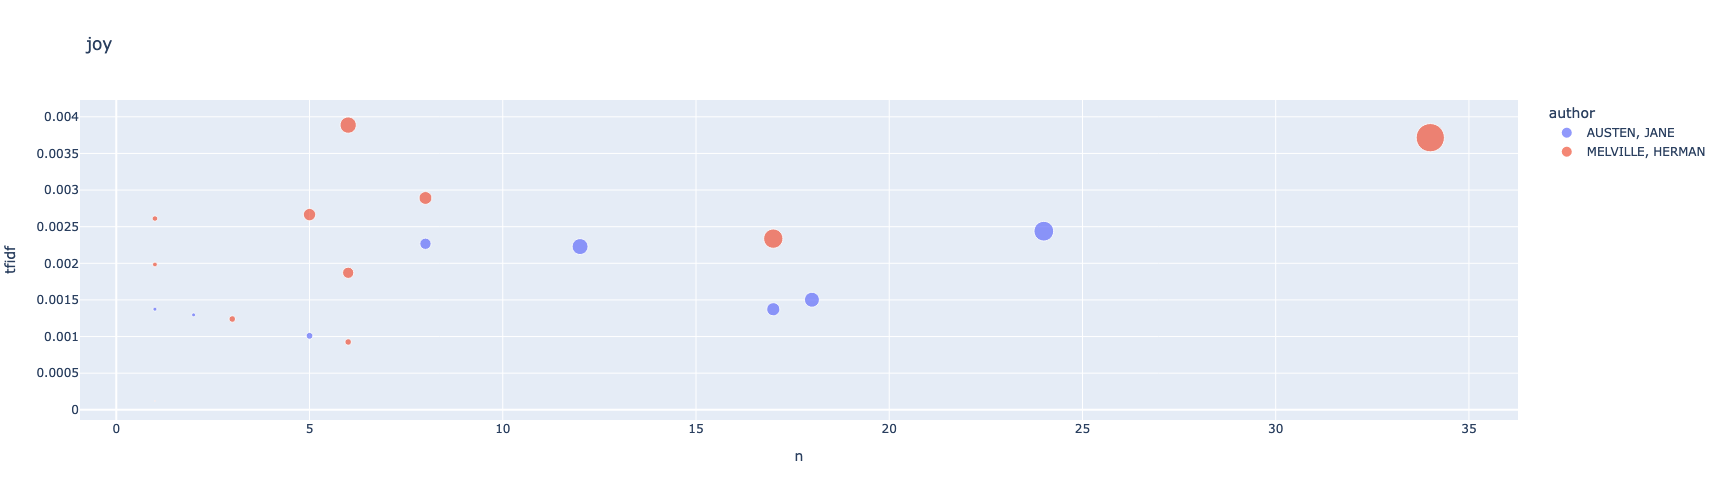

In [62]:
top_books_for_term('joy')

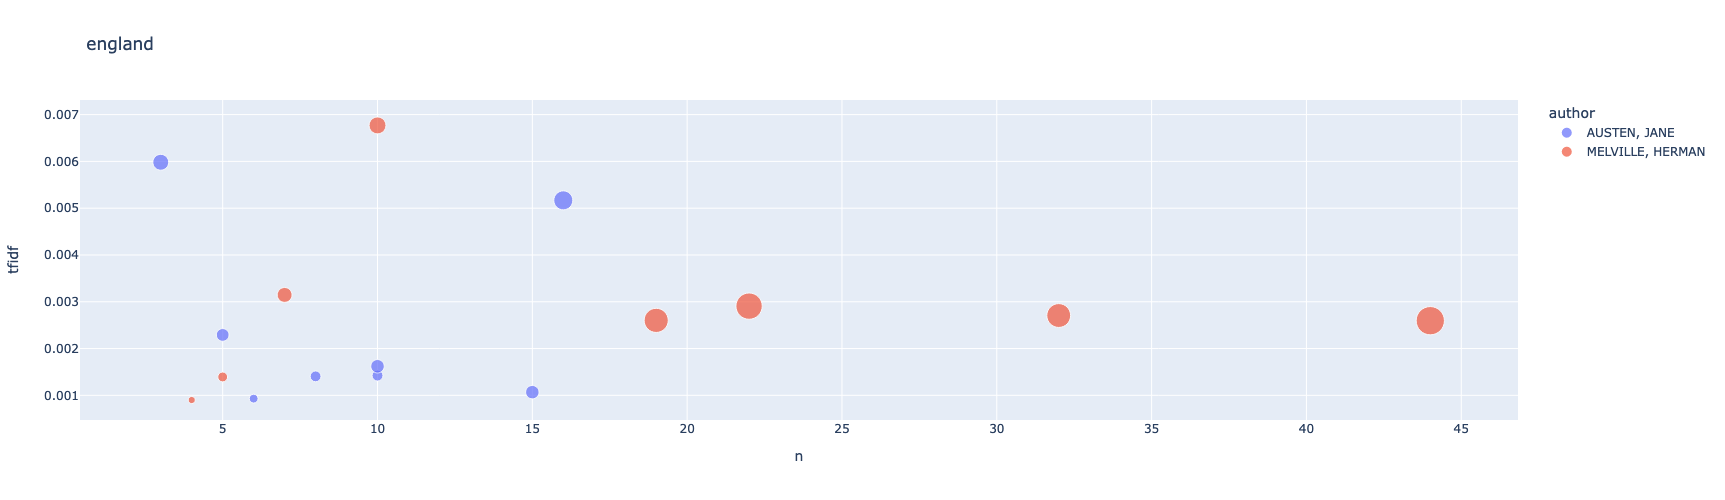

In [63]:
top_books_for_term('england')

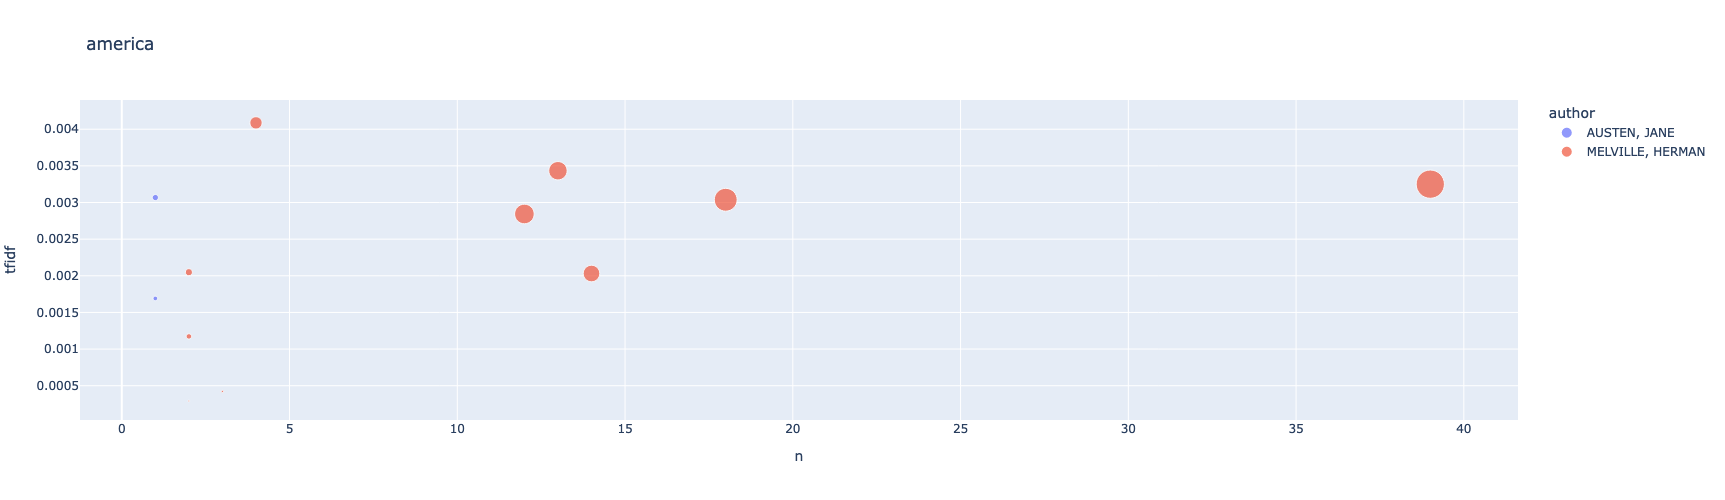

In [64]:
top_books_for_term('america')

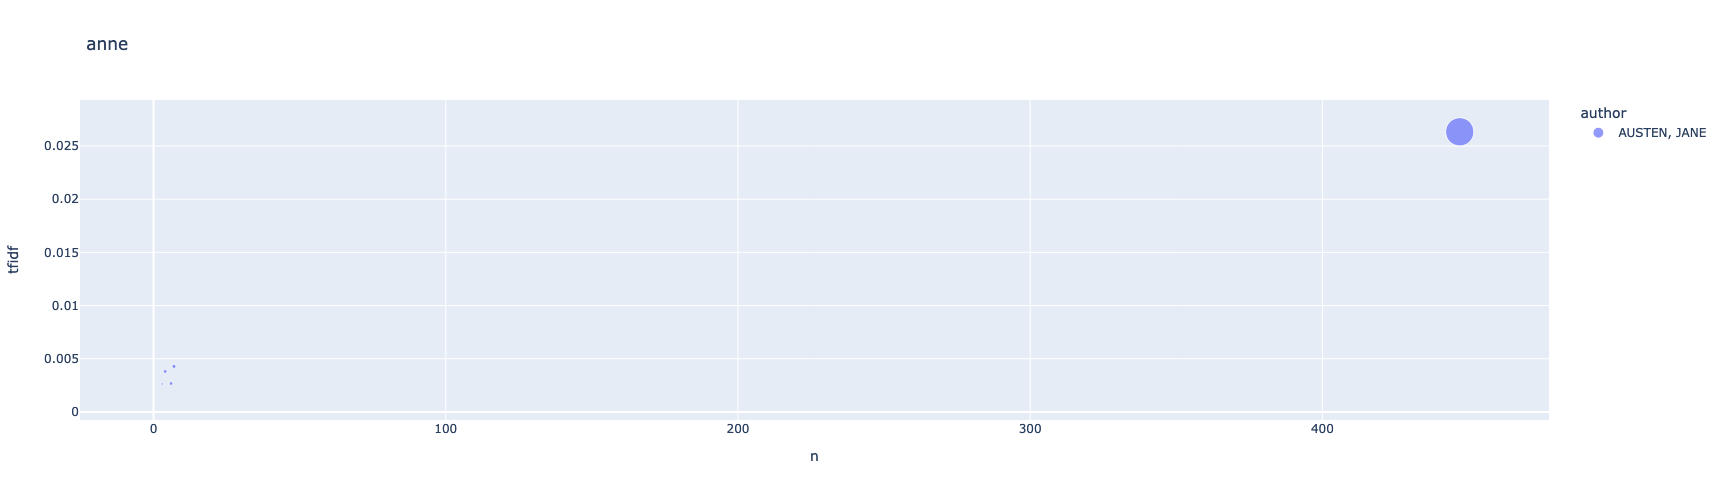

In [65]:
top_books_for_term('anne')

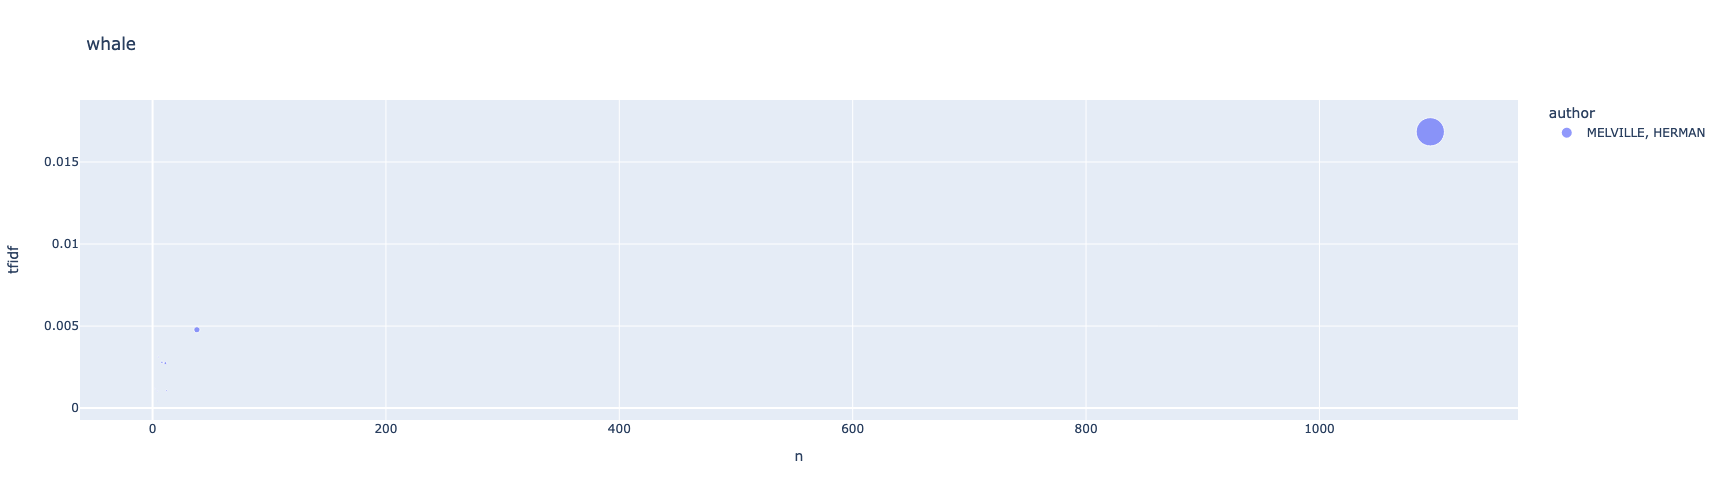

In [66]:
top_books_for_term('whale')

# Save

In [67]:
save_path = f"{output_dir}/{data_prefix}"
LIB.to_csv(f'{save_path}-LIB.csv')
VOCAB.to_csv(f'{save_path}-VOCAB-{bag}.csv')
# TOKEN.to_csv(f'{save_path}-TOKEN2.csv')
BOW.to_csv(f'{save_path}-BOW-{bag}.csv')
DTCM.to_csv(f'{save_path}-DTCM-{bag}.csv')
DOC.to_csv(f'{save_path}-DOC-{bag}.csv')
TFIDF.to_csv(f"{save_path}-TFIDF-{bag}.csv")